In [2]:
from IPython.display import HTML
from IPython.display import display
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as dat
from datetime import datetime
from scipy.interpolate import make_interp_spline, BSpline
import warnings
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np

# 1. Preparation of datasets 

In [3]:
#importing of datasets
load = pd.read_excel("load_weather_dataset.xlsx", sheet_name = "load", index_col = 0)
temp = pd.read_excel("load_weather_dataset.xlsx", sheet_name = "historical temperature", index_col = 0)
sun = pd.read_excel("load_weather_dataset.xlsx", sheet_name = "sunshine duration", index_col = 0)
covid = pd.read_csv("covid-stringency-index.csv")
#cleaning covid datset: 
coviduk = covid[covid['Entity']== 'United Kingdom' ]
coviduk = coviduk.set_index('Date')
#join covid with sun dataset
sun_covid = sun.join(coviduk, lsuffix='_caller', rsuffix='_other')

sun_covid = sun_covid.drop(columns=['Entity', 'Code'])
#replace NaN with 0 (i.e. no covid means 0 stringency index)
sun_covid['stringency_index'] = sun_covid['stringency_index'].fillna(0)
#drop column in temp
temp = temp.drop(columns=['Unnamed: 4', '(every 6 hours - 6am/12/6pm/24)'])
#rename column
load.columns = ['value']

Approach: 
1. taking weighted average of sun 
2. taking weighted average of temperature 
3. creating covid dummy with stringency index

We look before if the index are well set for the different dataset and if they finish the same day.

In [4]:
sun_covid.tail()

,Bristol,Leeds,London,stringency_index
2021-03-04,157.38028,134.61206,0.00000,0.0
2021-03-05,661.97906,247.85887,511.66028,0.0
2021-03-06,475.62286,540.63434,381.67856,0.0
2021-03-07,683.31670,650.92270,616.58380,0.0
2021-03-08,313.60535,85.22076,160.85106,0.0


In [5]:
coviduk.tail()

,Entity,Code,stringency_index
Date,,,
2021-02-22,United Kingdom,GBR,87.96
2021-02-23,United Kingdom,GBR,87.96
2021-02-24,United Kingdom,GBR,87.96
2021-02-25,United Kingdom,GBR,87.96
2021-02-26,United Kingdom,GBR,87.96


In [6]:
load.tail()

,value
Date,
2021-03-03,31165.583333
2021-03-04,30915.812500
2021-03-05,30367.833333
2021-03-06,27862.083333
2021-03-07,27075.104170


In [7]:
temp.tail(n=10)

,London,Leeds,Bristol
2021-03-07 12:00:00,4.506411,5.906828,4.840105
2021-03-07 18:00:00,6.546411,9.126828,6.700105
2021-03-08 00:00:00,4.106412,2.916829,2.910105
2021-03-08 06:00:00,1.386411,3.606829,1.050105
2021-03-08 12:00:00,7.646411,8.596828,7.900105
2021-03-08 18:00:00,10.096412,8.886828,8.690105
2021-03-09 00:00:00,5.000000,5.000000,3.000000
2021-03-09 00:00:00,2.000000,6.000000,3.000000
2021-03-09 00:00:00,7.000000,8.000000,8.000000
2021-03-09 00:00:00,8.000000,7.000000,5.000000


In [8]:
#weighted averate 
#population per city: 
london = 8982000
leeds = 792525
bristol = 467099
total = london + leeds + bristol
london = london/total
leeds = leeds/total
bristol = bristol/total
#average for sun 
L = []
for i, bris in enumerate(sun_covid['Bristol']): 
    avg = bris*bristol + sun_covid['Leeds'][i] * leeds + sun_covid['London'][i] * london
    L.append(avg)
sun_covid['avg_sun'] = L

#average temperature (how did you guys remove the spaces?)
L = []
for i, bris in enumerate(temp['Bristol']): 
    avg = bris*bristol + temp['Leeds '][i] * leeds + temp['London '][i] * london
    L.append(avg)
temp['avg_temp'] = L

#bring temp to day level 
temp=temp.groupby(pd.Grouper(freq="1D")).mean()

#join all tabels to for regression 
fulldf = temp.join(sun_covid, lsuffix='_temp', rsuffix='_sun')
fulldf = fulldf.drop(columns=['Bristol_temp','London ','London','Leeds ','Bristol_sun','Leeds'])
fulldf = fulldf.join(load, lsuffix='_caller', rsuffix='_other')
#replace na with 0 
fulldf = fulldf.fillna(0)

#we use a naive froecast for the last prevision of sun light
fulldf['avg_sun'][-1] = fulldf['avg_sun'][-2]

#we use a naive forecast for the last value of the stringency index
fulldf['stringency_index'][-11:] = fulldf['stringency_index'][-12] 

#fulldf.head()

# 2. Feature Engineering

In [9]:
#checkpoint
fulldf_copy = fulldf.copy()
#fulldf = fulldf_copy

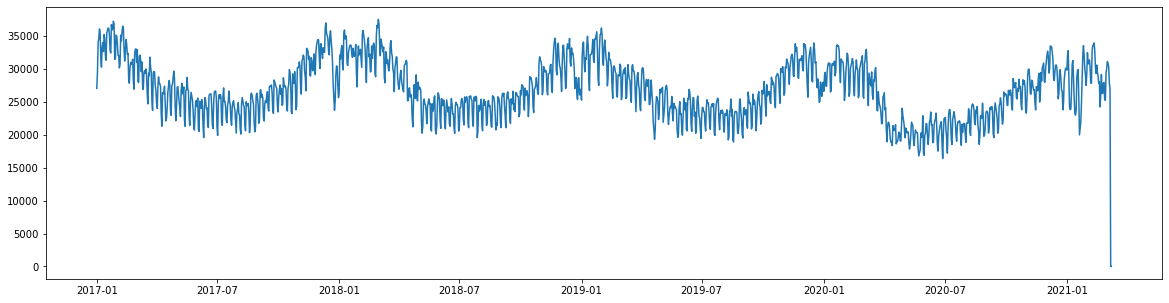

In [10]:
plt.figure(figsize = (20,5))
plt.plot(fulldf.index, fulldf['value'])

By plotting the load value along a year, we can see an important annual seasonality. We can also expect a weekly seasonality with a difference between normal weekday against the weekends.We can extract these thwo features and add them to our dataset.

Furtheremore, we can add different lag values of the load one day/month/year ago to try to catch the maximum insight of the time series. 

## 2.1 Adding lag values

In [11]:
#we reduce the memory of the dataset
fulldf['value'] = fulldf['value'].astype('float32')

#add lag values
fulldf["values-1"] = fulldf["value"].shift()
fulldf["values-2"] = fulldf["value"].shift()
fulldf["values-3"] = fulldf["value"].shift()
fulldf["values-7"] = fulldf["value"].shift(periods=7)
fulldf["values-14"] = fulldf["value"].shift(periods=7)
fulldf["values-30"] = fulldf["value"].shift(periods=30)
#fulldf["values-365"] = fulldf["value"].shift(periods=365)
fulldf.tail() 

,avg_temp,stringency_index,avg_sun,value,values-1,values-2,values-3,values-7,values-14,values-30
2021-03-05,4.002804,87.96,498.102327,30367.833984,30915.812500,30915.812500,30915.812500,27969.896484,27969.896484,30809.646484
2021-03-06,3.515665,87.96,398.263598,27862.083984,30367.833984,30367.833984,30367.833984,25298.541016,25298.541016,31410.187500
2021-03-07,3.425901,87.96,622.284586,27075.103516,27862.083984,27862.083984,27862.083984,25294.750000,25294.750000,30231.166016
2021-03-08,5.793223,87.96,161.965383,0.000000,27075.103516,27075.103516,27075.103516,29467.750000,29467.750000,27886.708984
2021-03-09,5.543177,87.96,161.965383,0.000000,0.000000,0.000000,0.000000,30112.625000,30112.625000,27851.750000


## 2.2 Multiplicative index for seasonality

We calculate the multiplicative index of seasonality by grouping the timeseries by year/week. We should only based this index on the training data (80% of dataset) and not the test set.

In [12]:
n_training = int(len(fulldf) * 0.8)

In [13]:
fulldf['weekday'] = fulldf.index.strftime('%w').astype('int16')
fulldf.loc[fulldf.weekday == 0, 'weekday'] = 7 #changing 0-sunday to 7-sunday

fulldf['month'] = fulldf.index.month.astype('int16')

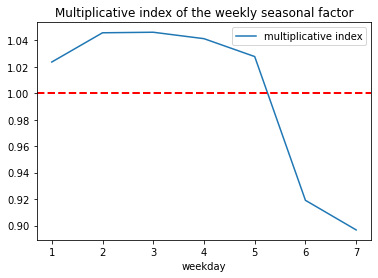

In [14]:
load_week = fulldf[:n_training].groupby('weekday').agg({'value':'mean'})
index_load_week = load_week / load_week.mean()

plt.plot(index_load_week, label = 'multiplicative index')
plt.title('Multiplicative index of the weekly seasonal factor')
plt.axhline(1, color = 'red', linestyle="--",  linewidth = 2)
plt.xlabel('weekday')
plt.legend()

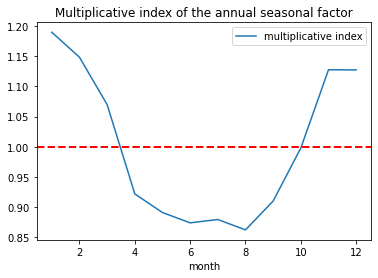

In [15]:
load_month = fulldf[:n_training].groupby('month').agg({'value':'mean'})
index_load_month = load_month / load_month.mean()

plt.plot(index_load_month, label = 'multiplicative index')
plt.title('Multiplicative index of the annual seasonal factor')
plt.axhline(1, color = 'red', linestyle="--",  linewidth = 2)
plt.xlabel('month')
plt.legend()

In [16]:
#we add the two multiplicative index to the fulldf dataset
index_load_week.columns = ['weekly_multiplicative_index']
index_load_week = index_load_week.reset_index()

index_load_month.columns = ['annual_multiplicative_index']
index_load_month = index_load_month.reset_index()

lost_index = fulldf.index
fulldf = fulldf.merge(index_load_week, how = 'left', on = 'weekday')
fulldf = fulldf.merge(index_load_month, how = 'left', on = 'month')
fulldf.index = lost_index
#fulldf

## 2.3. Adding Public Bank holiday as dummies

It will be worth adding the most imporant day off summarize in this website which are likely to have a very different energy load pattern. It must be done by hand on a csv.
https://www.gov.uk/bank-holidays

They are two different types of holidays, the one planned in avance (christmas, easter,...) and the one depending of the ear (university break).

In [17]:
#bank_holiday = pd.read_csv('bank_holiday.csv')
#left join of fulldf with creation of dummies "bank holidays"

## 2.4 Other features

Text(0.5, 1.0, 'load value in function of COVID')

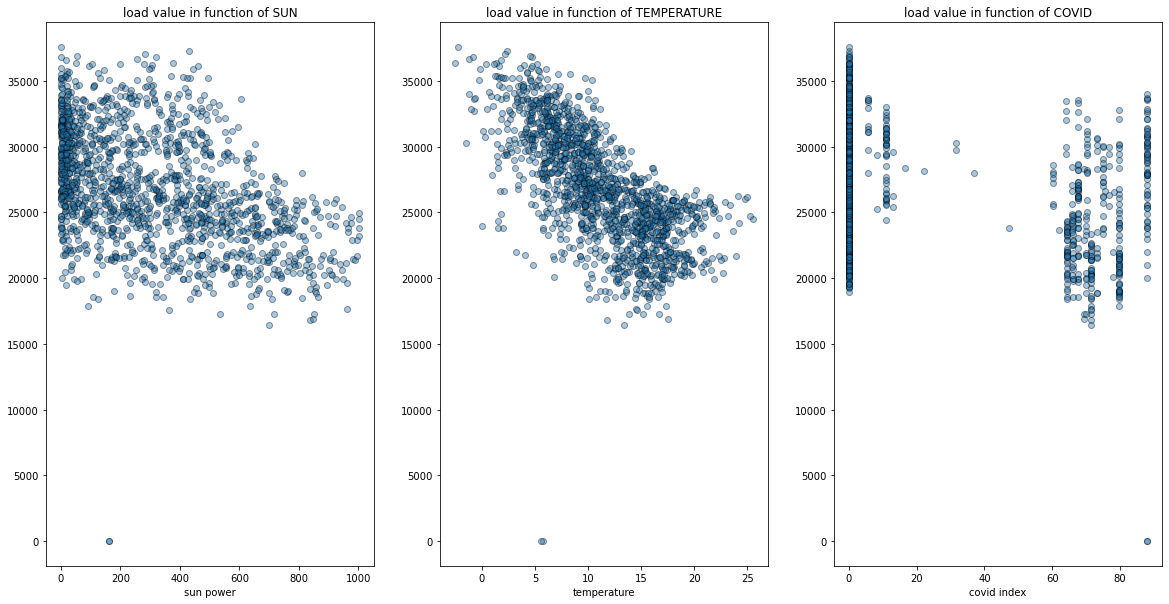

In [18]:
#plot relationship of variables 
fig, ax = plt.subplots(1,3, figsize =(20,10))
#plot the normalized data and give color depending on label 
ax[0].scatter(fulldf['avg_sun'], fulldf['value'], edgecolor='k',  alpha = 0.4)
ax[1].scatter(fulldf['avg_temp'], fulldf['value'], edgecolor='k',  alpha = 0.4)
ax[2].scatter(fulldf['stringency_index'], fulldf['value'], edgecolor='k',  alpha = 0.4)
              
ax[0].set_xlabel("sun power")  
ax[1].set_xlabel("temperature")  
ax[2].set_xlabel("covid index")

ax[0].set_title("load value in function of SUN")  
ax[1].set_title("load value in function of TEMPERATURE")  
ax[2].set_title("load value in function of COVID")

No key features extracted from these plots -> to remove/move ?

# 3. Model Choosing

Now, we split the dataset into a training and testing part to be able to evaluate different forecasting models.

In [19]:
# dependent vs indipendent variable 
Y = fulldf['value']
X = fulldf.drop(columns=['value'])
#remove last values of dataframe since it includes NaN
X = X.iloc[30:-1]
Y = Y.iloc[30:-1]
#split dataset
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle = False) # there were random_state=9? havent understood?

## 3.1. Linear Regression

In [20]:
x_train.columns

Index(['avg_temp', 'stringency_index', 'avg_sun', 'values-1', 'values-2',
       'values-3', 'values-7', 'values-14', 'values-30', 'weekday', 'month',
       'weekly_multiplicative_index', 'annual_multiplicative_index'],
      dtype='object')

In [21]:
#we removed weekday, weekend
col_to_select = ['avg_temp', 'stringency_index', 'avg_sun', 'values-1', 'values-2',
       'values-3', 'values-7', 'values-14', 'values-30',
       'weekly_multiplicative_index', 'annual_multiplicative_index']


#we select less columns for the linear regression
x_train_lin_reg = x_train.loc[:,col_to_select]
x_test_lin_reg = x_test.loc[:,col_to_select]

In [22]:
#regression model 
lin_reg_mod = LinearRegression()
#fit the regression model training set
lin_reg_mod.fit(x_train_lin_reg, y_train)

LinearRegression()

In [23]:
#predict on the test set 
pred = lin_reg_mod.predict(x_test_lin_reg)
# check accuracy against 
test_set_rmse = (np.sqrt(mean_squared_error(y_test, pred)))
print("Root Mean Square Error:\n")
print(test_set_rmse)

Root Mean Square Error:

2441.726085021102


In [24]:
lin_reg_mod.coef_

array([-1.76353592e+02, -3.09720104e+01, -1.23638690e+00,  1.18814160e-01,
        1.18814160e-01,  1.18814160e-01,  1.02367311e-01,  1.02367315e-01,
       -9.14509881e-02,  1.67135792e+04,  6.46522505e+03])

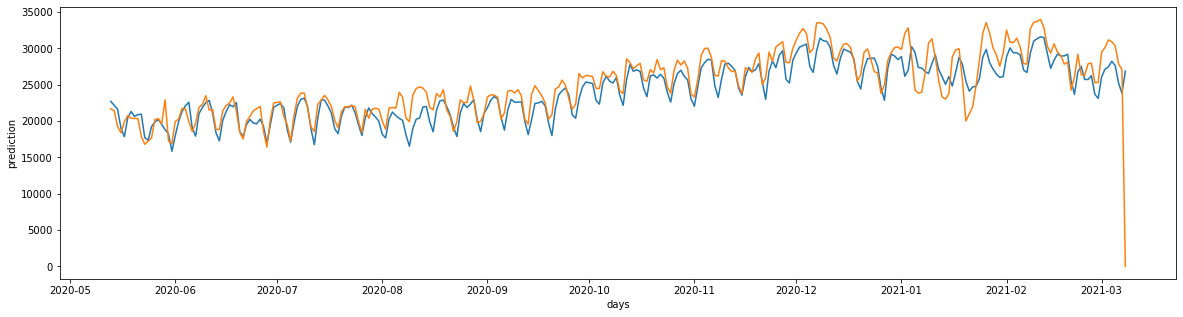

In [25]:
pred = pd.DataFrame(data = pred, index = y_test.index)
pred.column = ['value_pred']


plt.figure(figsize = (20,5))
plt.plot(pred)
plt.plot(y_test)
plt.xlabel("days")
plt.ylabel("prediction")
plt.show()

## 3.2 Neural network - LSTM

neural network model  (https://towardsdatascience.com/predicting-sales-611cb5a252de) 

In [26]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import math

In [27]:
#add specific features for NN model
#add month dummy 
#fulldf['day']=fulldf.index.day   #kill the score, do not add!

#autoregression term for days 1-7, one for 2 weeks and one for 1 month 
fulldf["values-2"] = fulldf["value"].shift(periods=2)
fulldf["values-3"] = fulldf["value"].shift(periods=3)
fulldf["values-4"] = fulldf["value"].shift(periods=4)
fulldf["values-5"] = fulldf["value"].shift(periods=5)
fulldf["values-6"] = fulldf["value"].shift(periods=6)

In [28]:
#if you need to suppress some column previously added
#fulldf = fulldf.drop(columns = ['values-4', 'values-5', 'values-6'])

fulldf.tail()

,avg_temp,stringency_index,avg_sun,value,values-1,values-2,values-3,values-7,values-14,values-30,weekday,month,weekly_multiplicative_index,annual_multiplicative_index,values-4,values-5,values-6
2021-03-05,4.002804,87.96,498.102327,30367.833984,30915.812500,31165.583984,30112.625000,27969.896484,27969.896484,30809.646484,5,3,1.027690,1.069807,29467.750000,25294.750000,25298.541016
2021-03-06,3.515665,87.96,398.263598,27862.083984,30367.833984,30915.812500,31165.583984,25298.541016,25298.541016,31410.187500,6,3,0.919101,1.069807,30112.625000,29467.750000,25294.750000
2021-03-07,3.425901,87.96,622.284586,27075.103516,27862.083984,30367.833984,30915.812500,25294.750000,25294.750000,30231.166016,7,3,0.896733,1.069807,31165.583984,30112.625000,29467.750000
2021-03-08,5.793223,87.96,161.965383,0.000000,27075.103516,27862.083984,30367.833984,29467.750000,29467.750000,27886.708984,1,3,1.023566,1.069807,30915.812500,31165.583984,30112.625000
2021-03-09,5.543177,87.96,161.965383,0.000000,0.000000,27075.103516,27862.083984,30112.625000,30112.625000,27851.750000,2,3,1.045653,1.069807,30367.833984,30915.812500,31165.583984


In [43]:
#remove first 30 values of dataframe since it includes NaN
df_adjusted = fulldf.iloc[30:]
df_adjusted = df_adjusted.drop(columns = ['weekday', 'month'])

#split dataset
X_train_1, X_test_1, y_train, y_test = train_test_split(df_adjusted.drop(columns=["value"]),df_adjusted.value, test_size = 0.2, shuffle=False)

scaler_x=preprocessing.MinMaxScaler(feature_range=(-1, 1))

X_train=scaler_x.fit_transform(X_train_1.values)
X_test=scaler_x.transform(X_test_1.values)

X_train = pd.DataFrame(X_train, columns=X_train_1.columns, index=X_train_1.index)
X_test = pd.DataFrame(X_test, columns=X_train_1.columns, index=X_test_1.index)


In [44]:
#run neural network model 
regr = MLPRegressor(hidden_layer_sizes = (112), validation_fraction = 0, max_iter=10000).fit(X_train, y_train)

In [45]:
#get the full test set performance 
nn_pred_full = regr.predict(X_test)
nn_pred_full=pd.Series(nn_pred_full, index=X_test.index)

#we renormalize the target values
pred=nn_pred_full
log_pred = np.array([math.log(i) if i>0 else 0 for i in pred])

actual=y_test
log_actual = np.array([math.log(i) if i>0 else 0 for i in actual])

#accuracy of the model 
MSE = mean_squared_error(pred, actual)
RMSE = math.sqrt(MSE)

log_MSE = mean_squared_error(log_pred, log_actual)
log_RMSE = math.sqrt(log_MSE)

In [46]:
print("Root Mean Square Error:")
print(RMSE)
print("Std:")
print(np.std(pred-actual)) 


#I am not sure the following score makes sense at all! (Alexis)
print('---------------\n')
print("Root Mean Square Error for log values:")
print(log_RMSE)
print("Std of the log values:")
print(np.std(log_pred-log_actual)) 

Root Mean Square Error:
2746.349455018818
Std:
2600.999685375961
---------------

Root Mean Square Error for log values:
0.8218645086554015
Std of the log values:
0.8214155985496298


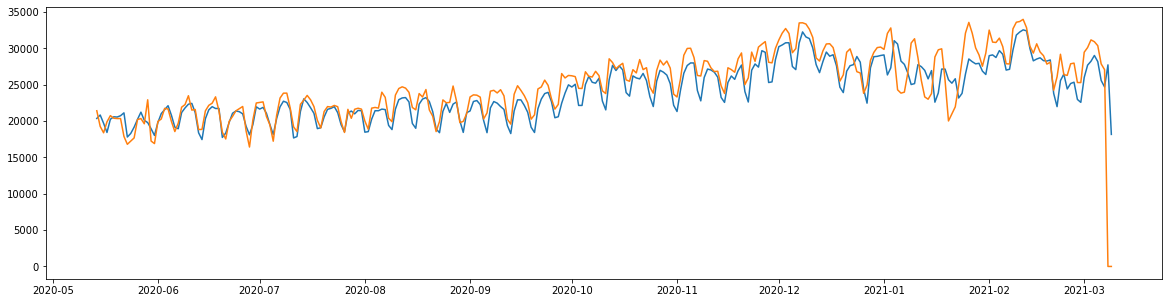

In [47]:
#plot real values 
#predicted = min_max_scaler.inverse_transform(nn_pred_full)
#actual = min_max_scaler.inverse_transform(y_test)
plt.figure(figsize = (20,5))
plt.plot(pred)
plt.plot(actual)

# REST is unchecked

In [49]:
#predition of day -2 
X_test_2 = X_test.iloc[-2].values.reshape(1,-1)
nn_pred_2 = regr.predict(X_test_2)
#add value -2 to the test dataset and need to rescale afterwards
X_test_1["values-1"][-1]= nn_pred_2
X_test=scaler_x.transform(X_test_1.values)
X_test = pd.DataFrame(X_test, columns=X_train_1.columns, index=X_test_1.index)

#prediction -1
X_test_1 = X_test.iloc[-1].values.reshape(1,-1)
nn_pred_1 = regr.predict(X_test_1)

print(nn_pred_2)
print(math.log(nn_pred_2))
print(nn_pred_1)
print(math.log(nn_pred_1))

[27729.77381543]
10.230261981902444
[28313.5813494]
10.251096874852482


In [97]:
#accuracy of the model 
predicted = np.std(fulldf['value']) * nn_pred_full + np.mean(fulldf['value']) 
actuals = np.std(fulldf['value']) * y_test + np.mean(fulldf['value']) 
#accuracy of the model 
MSE = mean_squared_error(actuals, predicted)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

12381980.17014512


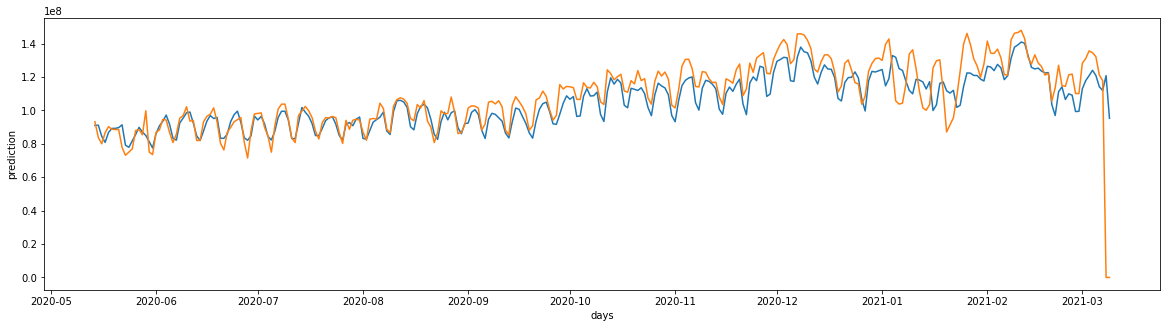

In [98]:
#plot real values 
plt.figure(figsize = (20,5))
plt.plot(predicted)
plt.plot(actuals)
plt.xlabel("days")
plt.ylabel("prediction")

plt.show()

## Hyperparameter adjustment 

In [65]:
#optimize hyperparameter 
error = []
for i in range(1,150,1):
    #run neural network model 
    regr = MLPRegressor([i],validation_fraction = 0, random_state=1, max_iter=10000).fit(X_train, y_train)
    nn_pred = regr.predict(X_test)
    #drop index
    y_test.reset_index(drop=True, inplace=True) 
    #accuracy of the model 
    predicted = np.std(fulldf['value']) * nn_pred + np.mean(fulldf['value']) 
    actuals = np.std(fulldf['value']) * y_test + np.mean(fulldf['value']) 
    #accuracy of the model 
    MSE = mean_squared_error(actuals, predicted)
    RMSE = math.sqrt(MSE)
    error.append(RMSE)


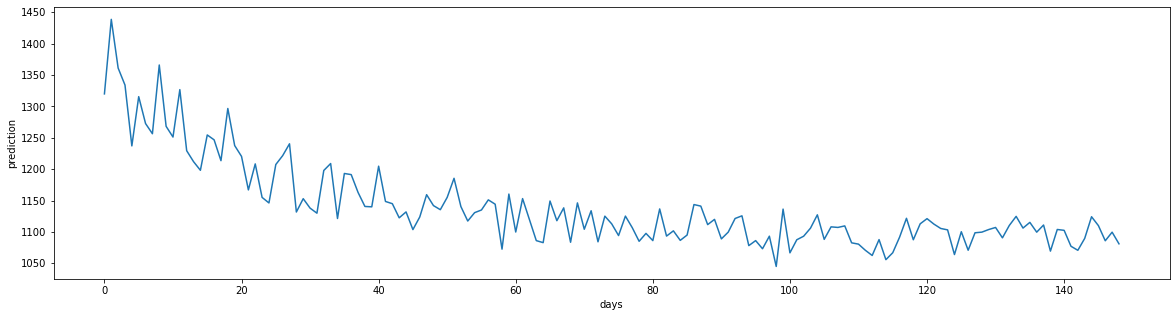

In [27]:
y = error
x = range(1,200,1)
plt.figure(figsize = (20,5))
plt.plot(y)
#plt.plot(x)
plt.xlabel("days")
plt.ylabel("prediction")
plt.show()

In [28]:
error = []
for i in range(1,50,1):
    #run neural network model 
    regr = MLPRegressor(hidden_layer_sizes = (112,i),validation_fraction = 0, random_state=1, max_iter=10000).fit(X_train, y_train)
    nn_pred = regr.predict(X_test)
    #drop index
    y_test.reset_index(drop=True, inplace=True) 
    #accuracy of the model 
    predicted = np.std(fulldf['value']) * nn_pred + np.mean(fulldf['value']) 
    actuals = np.std(fulldf['value']) * y_test + np.mean(fulldf['value']) 
    #accuracy of the model 
    MSE = mean_squared_error(actuals, predicted)
    RMSE = math.sqrt(MSE)
    error.append(RMSE)

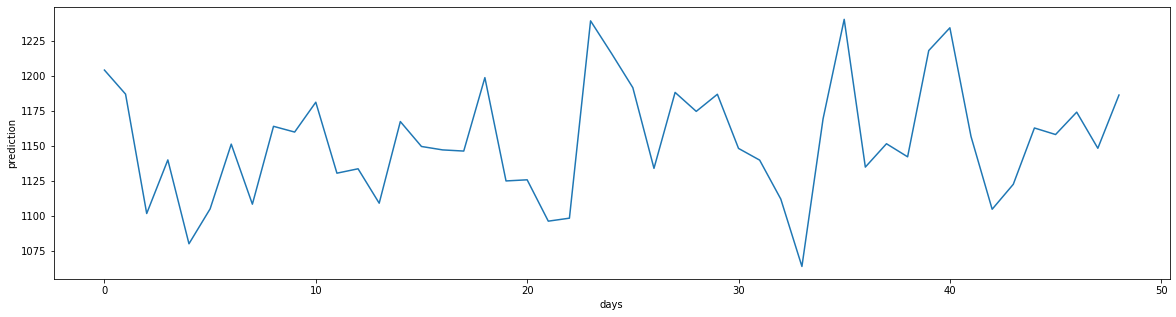

In [29]:
y = error
x = range(1,200,1)
plt.figure(figsize = (20,5))
plt.plot(y)
#plt.plot(x)
plt.xlabel("days")
plt.ylabel("prediction")
plt.show()

# Test with last different datapoints

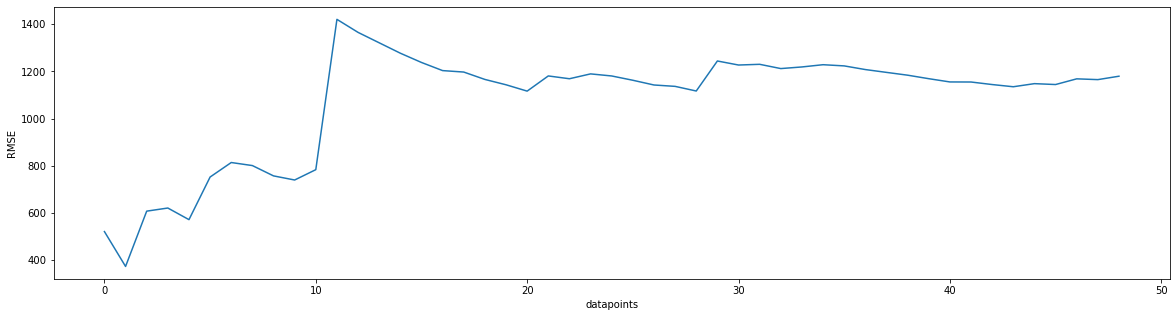

In [82]:
L = []
for i in range(1,50,1):    
    #run neural network model 
    regr = MLPRegressor(hidden_layer_sizes = (112) ,validation_fraction = 0, random_state=1, max_iter=10000).fit(X_train, y_train)
    #short term prediction
    n5_test = X_test.tail(n=i)
    n5_result = y_test.tail(n=i)
    #predict
    nn_pred = regr.predict(n5_test)
    #drop index
    y_test.reset_index(drop=True, inplace=True) 
    #accuracy of the model 
    predicted = np.std(fulldf['value']) * nn_pred + np.mean(fulldf['value']) 
    actuals = np.std(fulldf['value']) * n5_result + np.mean(fulldf['value']) 
    #accuracy of the model 
    MSE = mean_squared_error(actuals, predicted)
    RMSE = math.sqrt(MSE)
    L.append(RMSE)
    
y = L
x = range(1,50,1)
plt.figure(figsize = (20,5))
plt.plot(y)
#plt.plot(x)
plt.xlabel("datapoints")
plt.ylabel("RMSE")
plt.show()

In [78]:
#accuracy of the model 
predicted = np.std(fulldf['value']) * nn_pred + np.mean(fulldf['value']) 
actuals = np.std(fulldf['value']) * n5_result + np.mean(fulldf['value']) 

In [79]:
#accuracy of the model 
MSE = mean_squared_error(actuals, predicted)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

1143.1417620277368


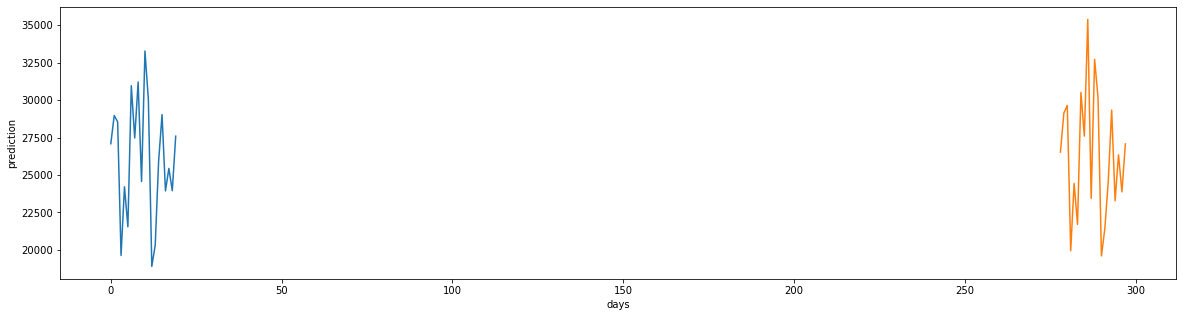

In [80]:
#plot real values 
plt.figure(figsize = (20,5))
plt.plot(predicted)
plt.plot(actuals)
plt.xlabel("days")
plt.ylabel("prediction")

plt.show()

# 4. Game prediction

In [165]:

regr = MLPRegressor(hidden_layer_sizes = (112) ,validation_fraction = 0, random_state=1, max_iter=10000).fit(X_train, y_train)
#short term prediction
n5_test = X_test.tail(n=1)
n5_result = y_test.tail(n=1)
#predict
nn_pred = regr.predict(n5_test)
#drop index
y_test.reset_index(drop=True, inplace=True) 
#accuracy of the model 
predicted = np.std(fulldf['value']) * nn_pred + np.mean(fulldf['value']) 
actuals = np.std(fulldf['value']) * n5_result + np.mean(fulldf['value']) 
#accuracy of the model 
MSE = mean_squared_error(actuals, predicted)
RMSE = math.sqrt(MSE)
print('Error')
print(RMSE)
print('Prediction')
print(predicted)
print('')




Error
1685.615500208798
Prediction
[20270.88663229]

4243.385695985998


In [125]:
fulldf.tail(n=10)

,Leeds,stringency_index,avg_sun,Leeds,avg_temp,value,values-1,values-7,month,quadratic,day,values-2,values-3,values-4,values-5,values-6,values-14,values-30
2021-02-27,578.52905,0.0,640.202825,6.309329,8.070879,25298.541667,27969.895833,24244.979167,2,5.878190e+08,27,27877.937500,26284.166667,26380.062500,29187.854167,26082.500000,30293.166667,30069.291667
2021-02-28,594.69556,0.0,650.955425,6.409328,6.373526,25294.750000,25298.541667,26082.500000,2,6.802968e+08,28,27969.895833,27877.937500,26284.166667,26380.062500,29187.854167,29346.791667,29097.208333
2021-03-01,459.48367,0.0,357.849832,4.839329,5.172722,29467.750000,25294.750000,29187.854167,3,8.519308e+08,1,25298.541667,27969.895833,27877.937500,26284.166667,26380.062500,30626.708333,27538.687500
2021-03-02,347.80000,0.0,449.110123,3.041829,4.942451,30112.625000,29467.750000,26380.062500,3,6.959077e+08,2,25294.750000,25298.541667,27969.895833,27877.937500,26284.166667,29497.229167,29346.187500
2021-03-03,0.00000,0.0,5.597931,3.026828,5.818560,31165.583333,30112.625000,26284.166667,3,6.908574e+08,3,29467.750000,25294.750000,25298.541667,27969.895833,27877.937500,28995.354167,32514.437500
2021-03-04,134.61206,0.0,17.594436,4.396828,5.689798,30915.812500,31165.583333,27877.937500,3,7.771794e+08,4,30112.625000,29467.750000,25294.750000,25298.541667,27969.895833,27834.666667,30862.270833
2021-03-05,247.85887,0.0,498.102327,3.949329,4.002804,30367.833333,30915.812500,27969.895833,3,7.823151e+08,5,31165.583333,30112.625000,29467.750000,25294.750000,25298.541667,28094.479167,30809.645833
2021-03-06,540.63434,0.0,398.263598,3.904329,3.515665,27862.083333,30367.833333,25298.541667,3,6.400162e+08,6,30915.812500,31165.583333,30112.625000,29467.750000,25294.750000,24244.979167,31410.187500
2021-03-07,650.92270,0.0,622.284586,4.184328,3.425901,27075.104170,27862.083333,25294.750000,3,6.398244e+08,7,30367.833333,30915.812500,31165.583333,30112.625000,29467.750000,26082.500000,30231.166667
2021-03-08,85.22076,0.0,161.965383,6.001828,5.793223,NaN,27075.104170,29467.750000,3,8.683483e+08,8,27862.083333,30367.833333,30915.812500,31165.583333,30112.625000,29187.854167,27886.708333
